<h1 style="text-align: center;">ENERGY CONSUMPTION PREDICTION</h1>
<h1 style="text-align: center;">(PART-3 Models and Fine Tuning)</h1>

# From Previous Notebook ....

## - Importing Necessary Libraries

In [1]:
# Importing needed libraries to be used throughout the project

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor,Ridge,ElasticNet
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import gc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Activation
from tensorflow.keras.optimizers import *

from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = '/content/drive/My Drive/feather_data'

In [4]:
import os

files = os.listdir(folder_path)
print(files)

['train_data.feather', 'building_data.feather', 'weather_train_data.feather', 'weather_test_data.feather', 'test_data.feather']


In [5]:
train_data = pd.read_feather(f'{folder_path}/train_data.feather')

building_data = pd.read_feather(f'{folder_path}/building_data.feather')

weather_train_data = pd.read_feather(f'{folder_path}/weather_train_data.feather')

## - Loading and Reducing Memory Usage of Data

In [6]:
# This function helps in optimizing the memory used by the dataframes by by modifying/altering thedatatype of each column.
# This method is inspired from the kaggle notebook titled: load data (reduce memory usage)
# Which is found at: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))

    return df


In [7]:
# Reducing Memory Usage of Data

train_data = reduce_mem_usage(train_data, 'Train Data')

building_data = reduce_mem_usage(building_data, 'Building Data')

weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')

Memory usage of Train Data is reduced by 71.82 %. Usage dropped from 616.95 MB to 173.84 MB.
Memory usage of Building Data is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather Train Data is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.


In [8]:
# Merging Data

train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [9]:
# Breaking Timestamp into Hour, Day, Month, Year

# This function firstly converts timestamp to date and then breaks down date into 6 new columns: hour, day, dayOfWeek, dayOfYear, month and year

def breakdown_timestamp(dataframe):

    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)

    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)

    return dataframe

In [10]:
train = breakdown_timestamp(train)

## - Applying Log Transformation to 'Meter Reading and 'Square Feet'

In [11]:
train['meter_reading'] = np.log1p(train['meter_reading'])

In [12]:
train['square_feet'] = np.log1p(train['square_feet'])

## - Data Preparation and Feature Engineering

In [13]:
# Removing Zero Meter Readings

zero_meter_readings = list(train[train['meter_reading'] == 0].index)
train.drop(zero_meter_readings, axis = 0, inplace = True)

In [14]:
# Dropping Columns with More than 50 % Missing Values

threshold = len(train) * 0.5
train.dropna(axis=1, thresh = threshold, inplace = True)

In [15]:
# Filling Missing Values

train['cloud_coverage'].fillna(train['cloud_coverage'].median(), inplace=True)
train['sea_level_pressure'].fillna(train['sea_level_pressure'].median(), inplace=True)
train['precip_depth_1_hr'].fillna(train['precip_depth_1_hr'].median(), inplace=True)
train['wind_direction'].fillna(train['wind_direction'].median(), inplace=True)
train['wind_speed'].fillna(train['wind_speed'].median(), inplace=True)
train['dew_temperature'].fillna(train['dew_temperature'].median(), inplace=True)
train['air_temperature'].fillna(train['air_temperature'].median(), inplace=True)

In [16]:
# adding new feature from existing ones to get better results

train['season'] = train['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else
                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else
                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else
                                                  'Winter')

train['isDayTime'] = train['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

In [17]:
# Encoding categorical data

categorical_features = ['primary_use', 'season']

encoder = preprocessing.LabelEncoder()

for i in categorical_features:

    train[i] = encoder.fit_transform(train[i])


## - Dropping Timestamp and Reducing Memory Usage Again

In [18]:
train = train.drop(['timestamp'],axis=1)

In [19]:
reduced_train_data = reduce_mem_usage(train, 'Train Data')

Memory usage of Train Data is reduced by 36.62 %. Usage dropped from 1241.96 MB to 787.16 MB.


## - Removing Least Important Features Generated by our Feature Selection Method

In [20]:
new_data = reduced_train_data[['building_id','square_feet','primary_use','meter','site_id','air_temperature','dayofyear','hour','isDayTime','dew_temperature','dayofweek', 'meter_reading']]

In [21]:
new_data.drop(['site_id','dew_temperature'],axis=1, inplace = True)

In [24]:
from google.colab import files

# Download the file to local system
files.download('processed_data.feather')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. Models and Fine Tuning

In [22]:
X_train = new_data.drop(['meter_reading'],axis = 1)

Y_train = new_data['meter_reading'].values

## 7.1 Baseline Model

Simple reference model for evaluating improvements.

In [26]:
def baselineModel(y_actual, y_pred):
    # RMSLE
    rmsle_score = np.sqrt(np.mean((y_actual - y_pred) ** 2))

    # RMSE
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)  # take sqrt of MSE to get RMSE

    # MAE
    mae = mean_absolute_error(y_actual, y_pred)

    # R2
    r2 = r2_score(y_actual, y_pred)

    # MAPE - avoid division by zero
    non_zero_idx = y_actual != 0
    mape = np.mean(np.abs((y_actual[non_zero_idx] - y_pred[non_zero_idx]) / y_actual[non_zero_idx])) * 100

    # Median Absolute Error
    median_ae = median_absolute_error(y_actual, y_pred)

    # Print all metrics
    print("Baseline Model Performance:")
    print(f"RMSLE:        {rmsle_score:.4f}")
    print(f"RMSE:         {rmse:.4f}")
    print(f"MAE:          {mae:.4f}")
    print(f"R² Score:     {r2:.4f}")
    print(f"MAPE:         {mape:.2f}%")
    print(f"Median AE:    {median_ae:.4f}")

The baseline score can be computed is median value of labels. The baseline score for 50% of the data is 1.772. So it can be expected that the baseline score could be more.

**Splitting the data for training and testing**

In [23]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [28]:
baselineModel(Y_train, np.full_like(Y_train, np.median(Y_train)))

Baseline Model Performance:
RMSLE:        1.7725
RMSE:         1.7727
MAE:          1.3965
R² Score:     nan
MAPE:         754.50%
Median AE:    1.1602


## Evaluation Metrics

**NOTE:** RMSLE is the most important evaluation metric for the models performance. Since we already applied log1p transformation to the target value 'Meter Reading', therefore, Root Mean Squared Error (RMSE) can be used directly.

- **RMSLE (Root Mean Squared Log Error)** : Penalizes underpredictions more, useful when target values span several magnitudes.
<center>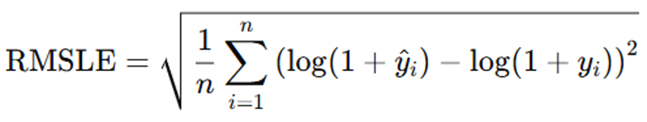</center>

- **RMSE (Root Mean Squared Error)** - Measures the square root of average squared errors — sensitive to large errors.
<center>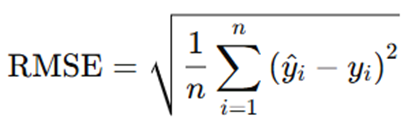</center>

- **MAE (Mean Absolute Error)** - Measures average magnitude of errors, treating all deviations equally.
<center>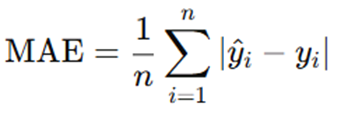</center>

- **R² (R-squared Score)** - Indicates how much variance in the target is explained by the model (1 = perfect).
<center>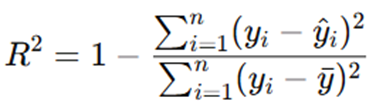</center>

- **MAPE (Mean Absolute Percentage Error)** - Shows error as a percentage of actual values — not ideal when actuals are near zero.
<center>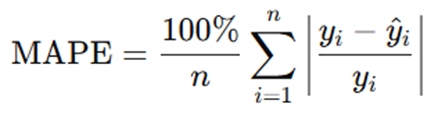</center>

- **MedianAE (Median Absolute Error)** - Median of all absolute errors — robust to outliers.
<center>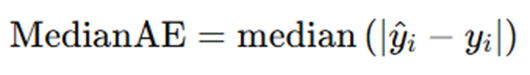</center>

In [29]:
def evaluate_model(model_name, y_true, y_pred):
    rmsle = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    non_zero_idx = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100
    median_ae = median_absolute_error(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"RMSLE:        {rmsle:.4f}")
    print(f"RMSE:         {rmse:.4f}")
    print(f"MAE:          {mae:.4f}")
    print(f"R² Score:     {r2:.4f}")
    print(f"MAPE:         {mape:.2f}%")
    print(f"Median AE:    {median_ae:.4f}")
    print("------------------------------------------------------")


## 7.2 Linear Regression

Models straight-line relationships between features and target.

In [30]:
linear_Regression = LinearRegression()
linear_Regression.fit(train_x, train_y)

LinearRegression()

In [31]:
# Predictions
train_pred = linear_Regression.predict(train_x)
test_pred = linear_Regression.predict(test_x)

In [32]:
# Train Metrics
evaluate_model("Linear Regression - Train", train_y, train_pred)

# Test Metrics
evaluate_model("Linear Regression - Test", test_y, test_pred)

Linear Regression - Train Performance Metrics:
RMSLE:        1.3811
RMSE:         1.3811
MAE:          1.0202
R² Score:     0.3929
MAPE:         655.57%
Median AE:    0.7587
------------------------------------------------------
Linear Regression - Test Performance Metrics:
RMSLE:        1.3812
RMSE:         1.3812
MAE:          1.0202
R² Score:     0.3923
MAPE:         623.58%
Median AE:    0.7588
------------------------------------------------------


**Calculating Prediction Score**

**Linear Regresssion Cross Validation**

In [33]:
lin_scores = cross_val_score(linear_Regression, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print("Linear Regression CV Scores:", lin_rmse_scores)
print("==========================================================================================")
print("Mean CV Score:", lin_rmse_scores.mean())

Linear Regression CV Scores: [1.38170799 1.38183736 1.38029682 1.37994614 1.38219218 1.38118286
 1.3830995  1.38021153 1.38149738 1.37906514]
Mean CV Score: 1.3811036903121514


## 7.3 ElasticNet Regression

Combines L1 and L2 for balanced regularization.

**Hyperparameter Tuning**

In [34]:
en_params = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'fit_intercept' : [False],
              'l1_ratio':[0.5]}

elasticnet = GridSearchCV(estimator = ElasticNet(),
                        param_grid = en_params,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

elasticnet.fit(train_x, train_y)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [False], 'l1_ratio': [0.5]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [35]:
print("Best ElasticNet Estimator is : ", elasticnet.best_estimator_)
print("Best ElasticNet Paramteres are : ", elasticnet.best_params_)

Best ElasticNet Estimator is :  ElasticNet(alpha=0.001, fit_intercept=False)
Best ElasticNet Paramteres are :  {'alpha': 0.001, 'fit_intercept': False, 'l1_ratio': 0.5}


**Building Best ElasticNet Estimator**

In [36]:
elastic_model = ElasticNet(**elasticnet.best_params_)
elastic_model.fit(train_x, train_y)

ElasticNet(alpha=0.001, fit_intercept=False)

**Calculating Prediction Score**

In [37]:
train_pred_en = elastic_model.predict(train_x)
test_pred_en = elastic_model.predict(test_x)

evaluate_model("ElasticNet - Train", train_y, train_pred_en)
evaluate_model("ElasticNet - Test", test_y, test_pred_en)

ElasticNet - Train Performance Metrics:
RMSLE:        1.4736
RMSE:         1.4736
MAE:          1.1243
R² Score:     0.3089
MAPE:         718.30%
Median AE:    0.8844
------------------------------------------------------
ElasticNet - Test Performance Metrics:
RMSLE:        1.4732
RMSE:         1.4732
MAE:          1.1241
R² Score:     0.3087
MAPE:         683.58%
Median AE:    0.8841
------------------------------------------------------


## 7.4 Ridge Regression

Adds L2 regularization to prevent overfitting.

**Hyperparameters Tuning**

In [38]:
ridge_params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'fit_intercept' : [True],
              'solver' : ['lsqr']}

ridge = GridSearchCV(estimator = Ridge(),
                        param_grid = ridge_params,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

ridge.fit(train_x, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [True], 'solver': ['lsqr']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [39]:
print("Best Ridge Estimator is :",ridge.best_estimator_)
print("Best Ridge Paramteres are : ", ridge.best_params_)

Best Ridge Estimator is : Ridge(alpha=0.0001, solver='lsqr')
Best Ridge Paramteres are :  {'alpha': 0.0001, 'fit_intercept': True, 'solver': 'lsqr'}


**Best Ridge Estimator**

In [40]:
Ridge = Ridge(**ridge.best_params_)
Ridge.fit(train_x, train_y)

Ridge(alpha=0.0001, solver='lsqr')

**Calculating Prediction Score**

In [41]:
train_pred_ridge = ridge.predict(train_x)
test_pred_ridge = ridge.predict(test_x)

evaluate_model("Ridge - Train", train_y, train_pred_ridge)
evaluate_model("Ridge - Test", test_y, test_pred_ridge)

Ridge - Train Performance Metrics:
RMSLE:        1.3827
RMSE:         1.3827
MAE:          1.0225
R² Score:     0.3915
MAPE:         656.14%
Median AE:    0.7634
------------------------------------------------------
Ridge - Test Performance Metrics:
RMSLE:        1.3828
RMSE:         1.3828
MAE:          1.0225
R² Score:     0.3910
MAPE:         624.18%
Median AE:    0.7632
------------------------------------------------------


## 7.5 Lasso Regression

Adds L1 regularization; helps with feature selection

**Hyperparameter Tuninig**

In [42]:
lasso_params = {'alpha':[0.001, 0.01, 0.1, 1, 10]}

lasso = GridSearchCV(estimator = Lasso(),
                        param_grid = lasso_params,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

lasso.fit(train_x, train_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [43]:
print("Best Lasso Estimator: ", lasso.best_estimator_)
print("Best Lasso Parameters: ", lasso.best_params_)

Best Lasso Estimator:  Lasso(alpha=0.001)
Best Lasso Parameters:  {'alpha': 0.001}


**Best Lasso Estimator**

In [44]:
lasso_model = Lasso(**lasso.best_params_)
lasso_model.fit(train_x, train_y)

Lasso(alpha=0.001)

**Calculating Prediction Score**

In [45]:
train_pred_lasso = lasso_model.predict(train_x)
test_pred_lasso = lasso_model.predict(test_x)

evaluate_model("Lasso - Train", train_y, train_pred_lasso)
evaluate_model("Lasso - Test", test_y, test_pred_lasso)

Lasso - Train Performance Metrics:
RMSLE:        1.3811
RMSE:         1.3811
MAE:          1.0203
R² Score:     0.3929
MAPE:         655.78%
Median AE:    0.7590
------------------------------------------------------
Lasso - Test Performance Metrics:
RMSLE:        1.3812
RMSE:         1.3812
MAE:          1.0203
R² Score:     0.3923
MAPE:         623.78%
Median AE:    0.7591
------------------------------------------------------


## 7.6 Decision Tree Regressor

Captures complex patterns; hyperparameter tuning via GridSearchCV.

**Hyperparameters Tuning**

In [46]:
dt_params = {'max_depth': [3,5,7,9,11,15]}


decission_tree = GridSearchCV(estimator = DecisionTreeRegressor(),
                        param_grid = dt_params,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(train_x, train_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [47]:
print("Best Decision Tree Estimator: ",decission_tree.best_estimator_)
print("Best Decision Tree Paramteres: ", decission_tree.best_params_)

Best Decision Tree Estimator:  DecisionTreeRegressor(max_depth=15)
Best Decision Tree Paramteres:  {'max_depth': 15}


**Best Decision Tree Estimator**

In [48]:
DecissionTree = DecisionTreeRegressor(**decission_tree.best_params_)
DecissionTree.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=15)

**Calculating Prediction Score**

In [49]:
train_pred_dt = DecissionTree.predict(train_x)
test_pred_dt = DecissionTree.predict(test_x)

evaluate_model("Decision Tree - Train", train_y, train_pred_dt)
evaluate_model("Decision Tree - Test", test_y, test_pred_dt)

Decision Tree - Train Performance Metrics:
RMSLE:        0.6077
RMSE:         0.6077
MAE:          0.3859
R² Score:     0.8825
MAPE:         84.50%
Median AE:    0.2384
------------------------------------------------------
Decision Tree - Test Performance Metrics:
RMSLE:        0.6099
RMSE:         0.6099
MAE:          0.3875
R² Score:     0.8815
MAPE:         82.59%
Median AE:    0.2396
------------------------------------------------------


## 7.7 SGD Regressor

Efficient for large datasets using stochastic gradient descent.

In [50]:
# Scaling the Data Prior to Passing it to the Model

x_train_scaled = preprocessing.scale(train_x)
x_test_scaled = preprocessing.scale(test_x)

**Hyperparameters Tuning**

In [51]:
sgd_params = {'alpha':[0.0001, 0.001],
             'eta0': [0.001],
             'penalty': ['l2'],
             'learning_rate': ['adaptive', 'invscaling'],
             'early_stopping': [True]}

sgd = GridSearchCV(estimator = SGDRegressor(),
                        param_grid = sgd_params,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 10,
                        return_train_score = True,
                        n_jobs = -1)

sgd.fit(x_train_scaled, train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001], 'early_stopping': [True],
                         'eta0': [0.001],
                         'learning_rate': ['adaptive', 'invscaling'],
                         'penalty': ['l2']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

In [52]:
print("Best SGDRegressor Estimator ",sgd.best_estimator_)
print("Best SGDRegressor Paramteres are : ", sgd.best_params_)

Best SGDRegressor Estimator  SGDRegressor(early_stopping=True, eta0=0.001, learning_rate='adaptive')
Best SGDRegressor Paramteres are :  {'alpha': 0.0001, 'early_stopping': True, 'eta0': 0.001, 'learning_rate': 'adaptive', 'penalty': 'l2'}


**Best SGDRegressor**

In [54]:
sgd_regressor = SGDRegressor(**sgd.best_params_)
sgd_regressor.fit(x_train_scaled, train_y)

SGDRegressor(early_stopping=True, eta0=0.001, learning_rate='adaptive')

**Calculating Prediction Score**

In [55]:
# Predictions
train_pred_sgd = sgd_regressor.predict(x_train_scaled)
test_pred_sgd = sgd_regressor.predict(x_test_scaled)

# Evaluation
evaluate_model("SGD Regressor - Train", train_y, train_pred_sgd)
evaluate_model("SGD Regressor - Test", test_y, test_pred_sgd)

SGD Regressor - Train Performance Metrics:
RMSLE:        1.3811
RMSE:         1.3811
MAE:          1.0202
R² Score:     0.3929
MAPE:         655.63%
Median AE:    0.7587
------------------------------------------------------
SGD Regressor - Test Performance Metrics:
RMSLE:        1.3812
RMSE:         1.3812
MAE:          1.0202
R² Score:     0.3923
MAPE:         623.64%
Median AE:    0.7588
------------------------------------------------------


## 7.8 3-Layer Neural Network

Learns complex non-linear relationships with early stopping to avoid overfitting.

In [62]:
from tensorflow.keras import backend as K

In [63]:
def NN_RMSLE(y_actual, y_pred):

    return K.sqrt(K.mean(K.square(y_pred - y_actual)))

In [57]:
# Splitting Training Data into Trainig and Validation Sets

train_xx, val_xx, train_yy, val_yy = train_test_split(train_x,train_y, test_size=0.2, random_state=42)

In [64]:
from keras.callbacks import EarlyStopping

model = Sequential()

earlyStop= EarlyStopping(monitor='val_loss', mode='min', patience=3)

model.add(layers.Dense(512, activation='relu',input_shape=(train_xx.shape[1],)))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1  ,activation='linear'))

model.compile(optimizer='adam', loss = NN_RMSLE)

model.fit(train_xx, train_yy, epochs = 15, batch_size = 2048, validation_data=(val_xx,val_yy),callbacks = earlyStop)

Epoch 1/15
5732/5732 ━━━━━━━━━━━━━━━━━━━━ 360s 62ms/step - loss: 2.5939 - val_loss: 1.3822
Epoch 2/15
5732/5732 ━━━━━━━━━━━━━━━━━━━━ 359s 62ms/step - loss: 1.3799 - val_loss: 1.4939
Epoch 3/15
5732/5732 ━━━━━━━━━━━━━━━━━━━━ 382s 63ms/step - loss: 1.2571 - val_loss: 1.8095
Epoch 4/15
5732/5732 ━━━━━━━━━━━━━━━━━━━━ 355s 62ms/step - loss: 1.2421 - val_loss: 1.8629


In [65]:
print('Neural Network Training RMSLE = ', model.evaluate(train_x, train_y, verbose=0))
print('Neural Network Testing RMSLE = ', model.evaluate(test_x, test_y, verbose=0))

Neural Network Training RMSLE =  1.849848747253418
Neural Network Testing RMSLE =  1.84933602809906


In [66]:
# Predictions
nn_train_pred = model.predict(train_x).flatten()
nn_test_pred = model.predict(test_x).flatten()

# Evaluate
evaluate_model("Neural Network - Train", train_y, nn_train_pred)
evaluate_model("Neural Network - Test", test_y, nn_test_pred)

458554/458554 ━━━━━━━━━━━━━━━━━━━━ 752s 2ms/step
114639/114639 ━━━━━━━━━━━━━━━━━━━━ 200s 2ms/step
Neural Network - Train Performance Metrics:
RMSLE:        1.8630
RMSE:         1.8630
MAE:          1.5269
R² Score:     -0.1047
MAPE:         410.33%
Median AE:    1.3597
------------------------------------------------------
Neural Network - Test Performance Metrics:
RMSLE:        1.8625
RMSE:         1.8625
MAE:          1.5263
R² Score:     -0.1049
MAPE:         389.22%
Median AE:    1.3594
------------------------------------------------------


# 8. Model Performance Comparison

In [97]:
metrics_df = pd.DataFrame([
    {
        "Model": "Baseline",
        "RMSLE": 1.7725,
        "RMSE": 1.7727,
        "MAE": 1.3965,
        "R2": None,
        "MAPE": 754.50,
        "MedianAE": 1.1602
    },
    {
        "Model": "Linear Regression",
        "RMSLE": 1.3812,
        "RMSE": 1.3812,
        "MAE": 1.0202,
        "R2": 0.3923,
        "MAPE": 623.58,
        "MedianAE": 0.7588
    },
    {
        "Model": "ElasticNet",
        "RMSLE": 1.4732,
        "RMSE": 1.4732,
        "MAE": 1.1241,
        "R2": 0.3087,
        "MAPE": 683.58,
        "MedianAE": 0.8841
    },
    {
        "Model": "Ridge",
        "RMSLE": 1.3828,
        "RMSE": 1.3828,
        "MAE": 1.0225,
        "R2": 0.3910,
        "MAPE": 624.18,
        "MedianAE": 0.7632
    },
    {
        "Model": "Lasso",
        "RMSLE": 1.3812,
        "RMSE": 1.3812,
        "MAE": 1.0203,
        "R2": 0.3923,
        "MAPE": 623.78,
        "MedianAE": 0.7591
    },
    {
        "Model": "Decision Tree",
        "RMSLE": 0.6099,
        "RMSE": 0.6099,
        "MAE": 0.3875,
        "R2": 0.8815,
        "MAPE": 82.59,
        "MedianAE": 0.2396
    },
    {
        "Model": "SGD Regressor",
        "RMSLE": 1.3812,
        "RMSE": 1.3812,
        "MAE": 1.0202,
        "R2": 0.3923,
        "MAPE": 623.64,
        "MedianAE": 0.7588
    },
    {
        "Model": "Neural Network",
        "RMSLE": 1.8625,
        "RMSE": 1.8625,
        "MAE": 1.5263,
        "R2": -0.1049,
        "MAPE": 389.22,
        "MedianAE": 1.3594
    }
])

# Set model names as index and round for presentation
metrics_df.set_index("Model", inplace=True)
metrics_df = metrics_df.round(4)

In [98]:
metrics_df

,RMSLE,RMSE,MAE,R2,MAPE,MedianAE
Model,,,,,,
Baseline,1.7725,1.7727,1.3965,NaN,754.50,1.1602
Linear Regression,1.3812,1.3812,1.0202,0.3923,623.58,0.7588
ElasticNet,1.4732,1.4732,1.1241,0.3087,683.58,0.8841
Ridge,1.3828,1.3828,1.0225,0.3910,624.18,0.7632
Lasso,1.3812,1.3812,1.0203,0.3923,623.78,0.7591
Decision Tree,0.6099,0.6099,0.3875,0.8815,82.59,0.2396
SGD Regressor,1.3812,1.3812,1.0202,0.3923,623.64,0.7588
Neural Network,1.8625,1.8625,1.5263,-0.1049,389.22,1.3594


In [99]:
metrics_df.sort_values("RMSLE")     # Best models by lowest RMSLE

,RMSLE,RMSE,MAE,R2,MAPE,MedianAE
Model,,,,,,
Decision Tree,0.6099,0.6099,0.3875,0.8815,82.59,0.2396
Linear Regression,1.3812,1.3812,1.0202,0.3923,623.58,0.7588
Lasso,1.3812,1.3812,1.0203,0.3923,623.78,0.7591
SGD Regressor,1.3812,1.3812,1.0202,0.3923,623.64,0.7588
Ridge,1.3828,1.3828,1.0225,0.3910,624.18,0.7632
ElasticNet,1.4732,1.4732,1.1241,0.3087,683.58,0.8841
Baseline,1.7725,1.7727,1.3965,NaN,754.50,1.1602
Neural Network,1.8625,1.8625,1.5263,-0.1049,389.22,1.3594


**Plotting Performance**

a. Bar plots for visual comparison:

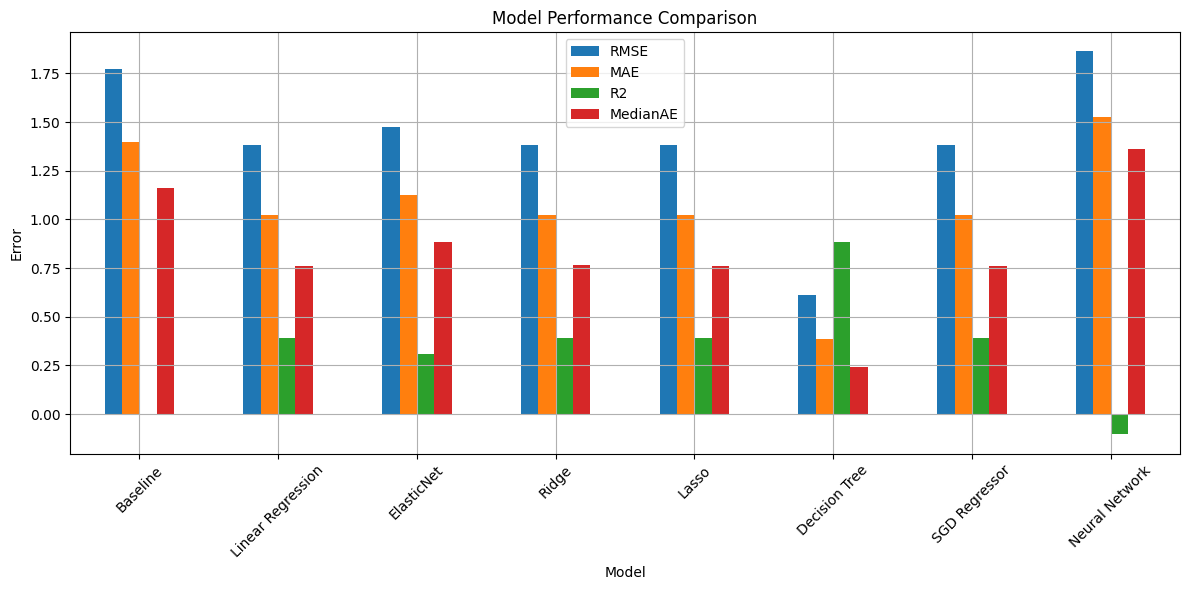

In [100]:
import matplotlib.pyplot as plt

metrics_df[['RMSE', 'MAE', 'R2', 'MedianAE']].plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

b. RMSLE Score plot

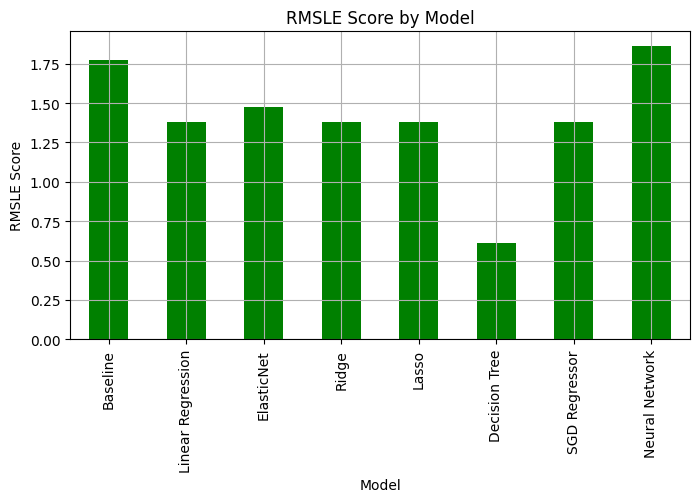

In [101]:
metrics_df['RMSLE'].plot(kind='bar', color='green', figsize=(8,4), title="RMSLE Score by Model")
plt.ylabel("RMSLE Score")
plt.grid(True)
plt.show()

## **Best Overall Model**

- Lowest RMSLE (since it's often the target metric for skewed regression problems)

- Low RMSE, MAE

- High R² Score

- Low MAPE (especially if interpretability of error as a percentage matters)

- Low MedianAE for robustness

**Decision Tree looks best here due to very low RMSLE, RMSE, and highest R².**

# 9. Key Findings

1. Out of all tested models, **Decision Tree Regressor** performed the best with an approximate RMSLE score of 0.6.
   
2. **Linear Regression, Ridge, Lasso and SGDRegressor** had competitively close scores, with Linear Regression talking the lead as the second best prediction method.

   
3. Our constructed **Neural Network** Performed worst out of all tested models, indicating its unsuitability for such problem.

   
4. Baseline Model's RMSLE: 1.7725; All models (except NN) beat it convincingly. Confirms that models are learning meaningful patterns, except Neural Net (which underperforms even baseline)

# 10.  Analyzing the Best Model

##  10.1 Viewing the Scores of the Hyperparameter Combinations Tested During the Grid Search

In [102]:
pd.DataFrame(decission_tree.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,33.581969,0.721182,0.663087,0.165231,3,{'max_depth': 3},-1.914567,-1.916316,-1.912353,-1.914412,0.001622,6,-1.914330,-1.913455,-1.915438,-1.914408,0.000811
1,53.475150,0.977778,0.649131,0.027373,5,{'max_depth': 5},-1.605538,-1.606929,-1.602004,-1.604824,0.002073,5,-1.604449,-1.603746,-1.606211,-1.604802,0.001037
2,72.965828,1.303161,0.898046,0.186158,7,{'max_depth': 7},-1.296241,-1.297142,-1.293259,-1.295547,0.001660,4,-1.295030,-1.294548,-1.296523,-1.295367,0.000841
3,88.505950,0.622543,0.880197,0.008797,9,{'max_depth': 9},-1.019235,-1.015169,-1.012483,-1.015629,0.002776,3,-1.016904,-1.013273,-1.015566,-1.015248,0.001499
4,105.052405,0.918309,1.122452,0.066820,11,{'max_depth': 11},-0.722920,-0.718741,-0.719844,-0.720501,0.001768,2,-0.721179,-0.716033,-0.721682,-0.719631,0.002553
5,124.123289,9.458227,1.554652,0.196266,15,{'max_depth': 15},-0.374334,-0.370920,-0.368244,-0.371166,0.002493,1,-0.369542,-0.364535,-0.364631,-0.366236,0.002338


## 10.2 Viewing the Relative Importance of Each Attribute for Making Accurate Predictions

In [103]:
features_list = ['building_id','square_feet','primary_use','meter','air_temperature','dayofyear','hour','isDayTime','dayofweek']

features_importance = decission_tree.best_estimator_.feature_importances_

sorted(zip(features_importance, features_list), reverse=True)

[(np.float64(0.5081627432690458), 'square_feet'),
 (np.float64(0.25492382692978094), 'building_id'),
 (np.float64(0.10511460991353737), 'meter'),
 (np.float64(0.05044856778994517), 'air_temperature'),
 (np.float64(0.04678807635866875), 'primary_use'),
 (np.float64(0.018370989364726042), 'dayofyear'),
 (np.float64(0.007119953079976261), 'isDayTime'),
 (np.float64(0.006198908865141003), 'hour'),
 (np.float64(0.00287232442917872), 'dayofweek')]

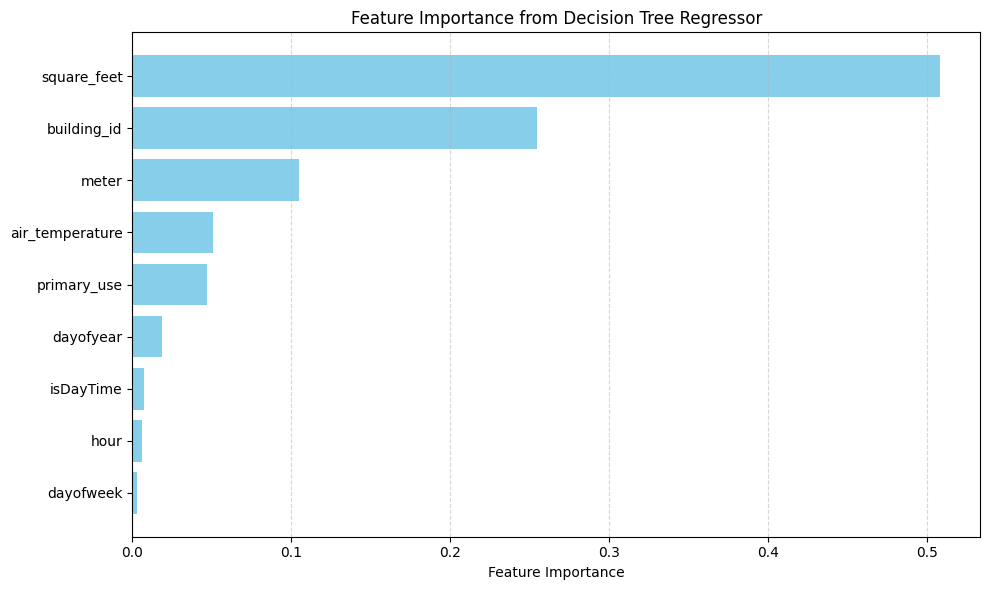

In [104]:
import matplotlib.pyplot as plt

# Feature names and their importances
features_list = ['building_id','square_feet','primary_use','meter','air_temperature','dayofyear','hour','isDayTime','dayofweek']
features_importance = decission_tree.best_estimator_.feature_importances_

# Combine and sort
sorted_features = sorted(zip(features_importance, features_list), reverse=True)
importances, names = zip(*sorted_features)

# Plotting
plt.figure(figsize=(10,6))
plt.barh(names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Decision Tree Regressor")
plt.gca().invert_yaxis()  # most important at the top
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations**
1. Square Feet attribute contributes the most towards predicting the amount of energy consumption.
2. Building Id is the second highly influencing factor, with an importance of 0.25.
3. It seems that attributes relating to time and date do not affect energy consumption much.

**Ensemble Methods**
- We believe that Random Forest Regressor might offer better performance as they rely on Decision Trees and this ensemble can further enhance performance. Unfortunately, due to extremely slow running times/sessions crashing, we were unable to test this theory.

## 10.3 Comparing model metrics across train and test sets to evaluate overfitting or generalization

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Train and Test performance metrics
dt_metrics_train = {
    "RMSLE": 0.6077,
    "RMSE": 0.6077,
    "MAE": 0.3859,
    "R2": 0.8825,
    "MAPE": 84.50,
    "MedianAE": 0.2384
}

dt_metrics_test = {
    "RMSLE": 0.6099,
    "RMSE": 0.6099,
    "MAE": 0.3875,
    "R2": 0.8815,
    "MAPE": 82.59,
    "MedianAE": 0.2396
}

# Combine into DataFrame
dt_comparison_df = pd.DataFrame([dt_metrics_train, dt_metrics_test], index=["Train", "Test"])
dt_comparison_df.round(4)

,RMSLE,RMSE,MAE,R2,MAPE,MedianAE
Train,0.6077,0.6077,0.3859,0.8825,84.50,0.2384
Test,0.6099,0.6099,0.3875,0.8815,82.59,0.2396


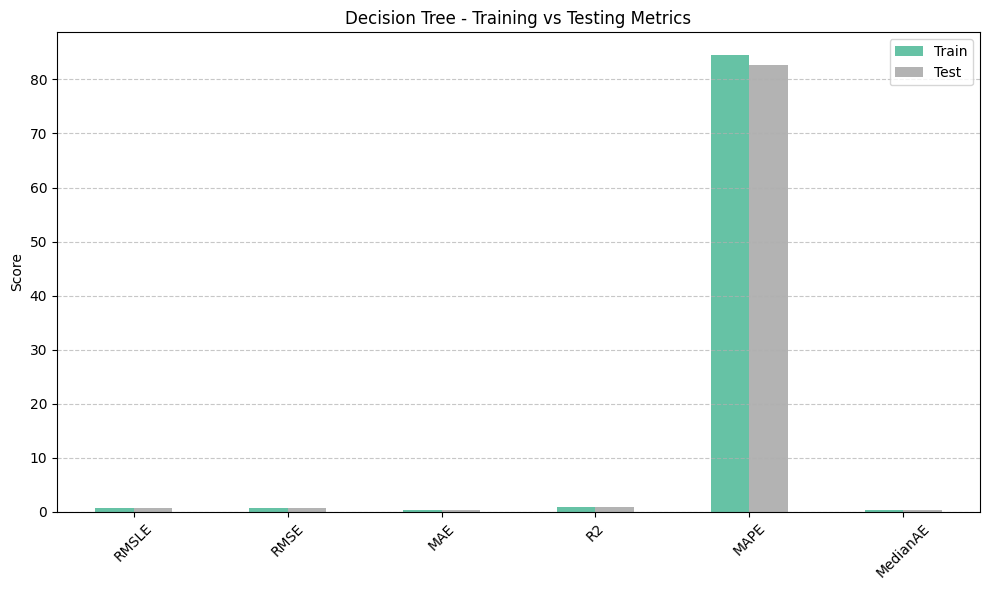

In [107]:
dt_comparison_df.T.plot(kind="bar", figsize=(10, 6), colormap="Set2")
plt.title("Decision Tree - Training vs Testing Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- This plot shows side-by-side comparison of key metrics for training and testing sets.

- Since the training and test scores are very close, it indicates that the model generalizes well and is not overfitting.

## 10.4 Scatter plot to visually inspect how close predictions are to the actual values

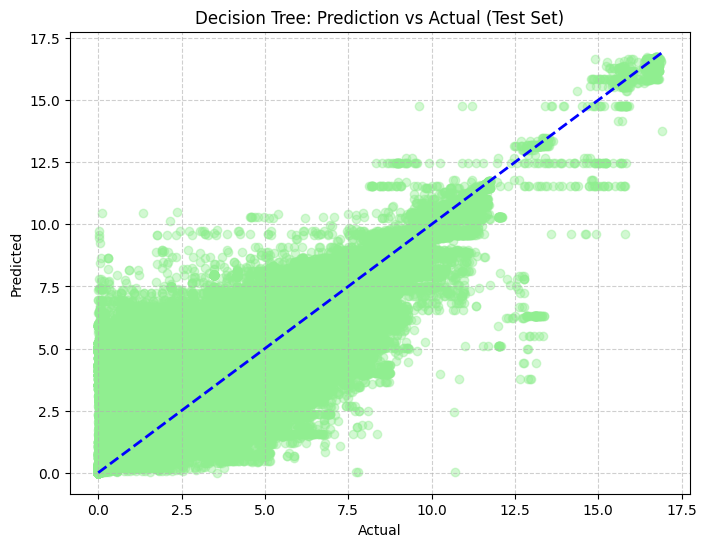

In [116]:
from sklearn.metrics import r2_score

# Get predictions
y_train_pred = DecissionTree.predict(train_x)
y_test_pred = DecissionTree.predict(test_x)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(test_y, y_test_pred, alpha=0.4, color='LightGreen')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'b--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree: Prediction vs Actual (Test Set)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

- This plot helps you visually inspect how close the model's predictions are to the actual target values.

- Points close to the blue dashed line (which represents perfect prediction) indicate good predictive accuracy.

# 11.  Conclusion

- Built and evaluated multiple regression models on the ASHRAE energy prediction dataset.

- Explored **baseline, linear, non-linear, ensemble, and neural network models**.

- Evaluated models using key metrics: **RMSLE, RMSE, MAE, R², MAPE, and MedianAE**.

- **Decision Tree Regressor** with tuned hyperparameters emerged as the best model.

- Grid Search helped identify optimal configurations, improving performance.

- Insights from model performance can guide energy optimization strategies in buildings.

# **Saving Models to Local Machine**

In [117]:
import joblib

# Save the trained model to a file
joblib.dump(DecissionTree, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

In [118]:
# Download the saved model to your local machine
files.download('decision_tree_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [119]:
# Save other models
joblib.dump(elastic_model, 'elastic_net_model.pkl')
joblib.dump(Ridge, 'ridge_model.pkl')
joblib.dump(lasso_model, 'lasso_model.pkl')
joblib.dump(sgd_regressor, 'sgd_regressor_model.pkl')
joblib.dump(model, 'neural_network_model.pkl')

['neural_network_model.pkl']

In [120]:
# Download the saved models
files.download('elastic_net_model.pkl')
files.download('ridge_model.pkl')
files.download('lasso_model.pkl')
files.download('sgd_regressor_model.pkl')
files.download('neural_network_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(linear_Regression, 'linear_regression_model.pkl')

In [ ]:
files.download('linear_regression_model.pkl')

In [ ]:
# Save datasets
train_y_df = pd.Series(train_y, name='target')
train_y_df.to_csv('train_y.csv', index=False)

train_x_df = pd.DataFrame(train_x)
train_x_df.to_csv('train_x.csv', index=False)

In [24]:
# Save datasets
test_x_df = pd.DataFrame(test_x)
test_x_df.to_csv('test_x.csv', index=False)

test_y_df = pd.Series(test_y, name='target')
test_y_df.to_csv('test_y.csv', index=False)

In [35]:
from google.colab import files

files.download('train_x.csv')
files.download('train_y.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
from google.colab import files

files.download('test_x.csv')
files.download('test_y.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>